# The Question
How do estimates of forest growth and yield produced by the Forest Vegetation Simulator (FVS) compare to historical and contemporary data and accounts? Are additional adjustments needed to the model to make it more accurate or informative for decision-making?

# The Data Sources
Four general data sources are considered:
1. Data I produced using the the Forest Vegetation Simulator
2. Several published Yield Tables for Douglas-fir
3. Remeasurements from permanent forest research plots published in the literature
4. Plot measurements collected from Oregon and Washington by the USDA Forest Service's Forest Inventory & Analysis (FIA) program.

#### 1. Forest Vegetation Simulator

The [Forest Vegetation Simulator (FVS)](https://www.fs.fed.us/fvs/index.shtml) is an [open-source](https://sourceforge.net/projects/open-fvs/) project of the USDA Forest Service, which they succinctly describe as:
>*`The Forest Vegetation Simulator (FVS) is a forest growth simulation model. It simulates forest vegetation change in response to natural succession, disturbances, and management. It recognizes all major tree species and can simulate nearly any type of management or disturbance at any time during the simulation. Outputs include tree volumes, biomass, density, canopy cover, harvest yields, fire effects, and much, much more.`*

I performed 230 stochastic simulations of the development of Douglas-fir plantations from establishment up to 200 years of age using the ORGANON Pacific Coast [Variant](https://www.fs.fed.us/fmsc/ftp/fvs/docs/overviews/FVSop_Overview.pdf) of FVS. These simulations were executed using a parallel processing workflow developed in Python using Jupyter Notebooks. 

Site Index is a measure of the productive potential of a site, and describes the average height of dominant trees reached in a forest stand at some benchmark age (usually 50 or 100 years). More productive sites yield taller and larger trees more quickly, and thus have higher Site Indices than less productive sites. Simulations were run for Site Indices ranging from 50 to 160 using a step of 5.  This produced 23 different Site Index values, each of which was simulated stochastically 10 times.

#### 2. Yield Tables
To further assess the data produced using FVS, simulated outputs are compared to canonical examples from the forestry literature. Yield Tables, or Yield Curves, have long been employed to capture common patterns of forest growth and development over time. They are typically based on fitting a model (regression or simulation) to numerous field observations recorded throughout a region, typically including a network of plots that have been remeasured over many years. 

As the name suggests, Yield Tables were developed with primary emphases on utility for timber management and include descriptions of the number, size, and volume of trees over time. In this analysis, I consider Yield Tables published by:
>`Schumacher, F.X. (1930). "Yield, stand and volume tables for Douglas fir in California" (Bulletin No. 491). University of California, Berkeley, Agricultural Experiment Station: Berkeley, CA.` [link to PDF](http://www.fire.ca.gov/resource_mgt/downloads/forestry/yield_tables/YieldTableDouglasFirSchumacher.pdf)

>`McArdle, R.E., Meyer, W.H., Bruce, D. (1961). "The Yield of Douglas Fir in the Pacific Northwest" (Technical Bulletin No. 201). USDA Forest Service, Pacific Northwest Forest and Range Experiment Station: Washington, D.C.` [link to PDF](https://naldc.nal.usda.gov/download/CAT40000043/PDF)

>`Chambers, C.J. (1980). "Empirical Growth and Yield Tables for the Douglas Fir Zone" (DNR Report No. 41). Washington Department of Natural Resources: Olympia, WA.` [link to PDF](ftp://ww4.dnr.wa.gov/frc/DNR_EmpiricalYieldTables/DNR%2041_Douglas-fir.pdf)

>`Curtis, R.O., Clendenen, G.W., Reukema, D.L., DeMars, D.J. (1982). "Yield Tables for Managed Stands of Coast Douglas-Fir" (General Technical Report No. PNW-GTR-135). USDA Forest Service, Pacific Northwest Forest and Range Experiment Station: Portland, OR.` [link to PDF](https://www.fs.fed.us/pnw/pubs/pnw_gtr135.pdf)

>`Mitchell, K.J., Cameron, I.R. (1985). "Managed stand yield tables for coastal Douglas-fir: initial density and precommercial thinning" (Land Management Report No. 31). British Columbia Ministry of Forests, Research Branch: Victoria, B.C.` [link to PDF](https://www.for.gov.bc.ca/hfd/pubs/Docs/Mr/Lmr/Lmr031.pdf)

>`Stand Managegement Cooperative (2016). "SMC Plantation Yield Calculator". Web application (accessed May 4, 2018).` (http://www.sefs.washington.edu/research.smc/research/pyc/index.html)

In general, each Yield Table in documents like these follow the trajectory of a single variable of interest (e.g., number of trees per acre) over time depending on the productivity of a forest, which is quantified using Site Index and often categorized into five major Site Classes, `I-V`, with `I` beyond the most productive. 

#### 3. Long-term Plot Data
I transcribed data from a couple of the studies that have conducted long-term measurements of forest plots to  investigate the changes in forest conditions over time have been published. These data provide a deep (in terms of time), but relatively narrow (in terms of number of independent plots) glimpse at forest growth and yield: 
>`Curtis, R.O., Marshall, D.D. (2002). "Levels-of-growing-stock cooperative study in Douglas-fir: report no. 14—Stampede Creek, 30-year results" (Research Paper No. PNW-RP-543). U.S. Department of Agriculture, Forest Service, Pacific Northwest Research Station, Portland, OR.` [link to PDF](https://www.fs.fed.us/pnw/pubs/pnw_rp543.pdf)

>`Williamson, R.L. (1963). "Growth and yield records from well-stocked stands of Douglas-fir" (Research Paper No. PNW-RP-4). U.S. Department of Agriculture, Forest Service, Pacific Northwest Forest and Range Experiment Station, Portland, OR.` [link to PDF](https://www.fs.fed.us/pnw/olympia/silv/publications/opt/74_Williamson1963.pdf)

####  4. FIA Data
Thousands of forest inventory plots are measured every year by the USDA Forest Service across the country. These data provide a broad (in terms of number of independent plots), but relatively shallow (in terms of measurements over time) overview of forest growth and yield. FIA data was downloaded for Oregon and Washington, and results for Douglas-fir forests were queried from these databases.

These data were queried from the Access databases, and cleaned/formatted in Microsoft Excel. 

In [57]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
%matplotlib inline

In [58]:
sns.set_style('darkgrid')

#### Read the FVS simulation data from the PostgreSQL database

In [59]:
mgmtid = "PNx0"
# mgmtid in the query can be modified to swap out new scenarios for yield table creation, etc.

conn = psycopg2.connect("dbname='Rotations' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT summary.*, cases.mgmtid, CAST (cases.standid AS INT) AS siteindex
FROM summary, cases
WHERE summary.caseid = cases.caseid AND cases.mgmtid = '{}';
''' 
# read the query into a pandas dataframe
grow = pd.read_sql(SQL.format(mgmtid), conn)
conn.close()

In [60]:
# add a new variable, siteclass, to the dataframe by binning site index into categories
grow['siteclass'] = pd.cut(grow.siteindex, bins=[0,75,95,115,135,161], 
                           labels=[5, 4, 3, 2, 1], right=False).astype('int')
# calculate thousands of board feet and hundreds of cubic feet
grow['MBF'] = grow.bdft / 1000
grow['tcuft_CCF'] = grow.tcuft / 100
grow['mcuft_CCF'] = grow.mcuft / 100
grow['Curtis_RD'] = grow.ba / np.sqrt(grow.qmd)


print(grow.columns)
cols = ['age', 'tpa', 'ba', 'sdi', 'topht', 'qmd', 'bdft', 'tcuft']
grow[cols].describe()

Index(['caseid', 'standid', 'year', 'age', 'tpa', 'ba', 'sdi', 'ccf', 'topht',
       'qmd', 'tcuft', 'mcuft', 'bdft', 'rtpa', 'rtcuft', 'rmcuft', 'rbdft',
       'atba', 'atsdi', 'atccf', 'attopht', 'atqmd', 'prdlen', 'acc', 'mort',
       'mai', 'fortyp', 'sizecls', 'stkcls', 'mgmtid', 'siteindex',
       'siteclass', 'MBF', 'tcuft_CCF', 'mcuft_CCF', 'Curtis_RD'],
      dtype='object')


,age,tpa,ba,sdi,topht,qmd,bdft,tcuft
count,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000
mean,100.000000,152.716755,433.280594,524.256204,129.165429,27.218982,162794.253446,22787.470732
std,59.163935,109.726401,168.124042,187.778239,68.832544,13.611356,103653.161084,12646.197229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,65.000000,457.000000,519.000000,80.000000,17.802075,89386.250000,15759.500000
50%,100.000000,109.000000,514.000000,579.000000,123.000000,28.726950,157751.500000,23300.500000
75%,150.000000,240.000000,531.000000,632.000000,180.000000,37.392825,238727.250000,32100.000000
max,200.000000,370.000000,538.000000,751.000000,294.000000,55.425300,417440.000000,50319.000000


In [61]:
grow = grow.loc[grow.siteclass.between(2,4)]

## Generate Yield Tables from FVS Simulations
Our data includes 10 different simulations I ran for each of 23 different levels of site index. For each level of site index, a stochastic simulation approach was used to allow variability in model outputs. We need to summarize data across these 10 runs to produce classical Yield Tables.

In [62]:
metric = 'MBF' # choose a value we want to generate a table for

# to make Yield Tables, let's use the mean of the simulations
grow_group = grow.groupby(by=['siteindex', 'year']).mean().reset_index()

#tables = grow_group.loc[grow_group.year % 10 == 0] # trim the data to show every 10 years
#tables = tables.loc[tables.siteindex % 10 == 0] # trim the data to show site indices in multiples of 10

# use a pivot table to show value by year (row) and site index (column)
grow_group.loc[grow_group.year.between(20,100) & grow_group.siteindex.between(90,120)].pivot(index='year', # exclude ages <20
                                   columns='siteindex', 
                                   values=metric).style.format("{:,.1f}")

siteindex,90,95,100,105,110,115,120
year,,,,,,,
20,0.0,0.0,0.0,0.0,0.1,0.3,0.9
25,26.5,28.0,29.7,31.6,33.3,34.6,35.9
30,42.6,44.7,46.7,49.4,50.9,51.9,53.5
35,56.5,57.8,59.4,63.0,66.6,70.7,75.9
40,66.8,71.8,76.9,84.0,89.1,93.2,96.4
45,82.6,91.3,98.1,103.2,107.8,111.7,114.6
50,99.2,104.3,109.1,113.1,115.8,117.5,120.6
55,106.9,114.1,117.9,120.1,122.7,128.9,139.2
60,114.9,121.1,123.7,127.9,138.8,144.0,148.4


## Get the FIA Data

In [63]:
fia = pd.read_csv('FIA_conds_DF.csv')
print(fia.columns)
fia.describe()

Index(['condid', 'siteindex', 'site_baseage', 'stand_age', 'ba', 'df_ba',
       'tpa', 'bdft', 'tcuft', 'topht', 'df_pctba', 'siteclass', 'qmd'],
      dtype='object')


,condid,siteindex,site_baseage,stand_age,ba,df_ba,tpa,bdft,tcuft,topht,df_pctba,siteclass,qmd
count,2.101000e+03,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000,1895.000000,2059.000000,2065.000000,2101.000000,2101.000000,2101.000000
mean,1.707029e+14,108.963827,97.667777,77.624465,221.337903,204.737319,312.536347,37290.323274,8492.007251,98.175644,0.929938,2.777725,13.748393
std,1.571279e+14,19.750796,10.546318,77.747738,172.776842,165.722835,274.983443,43147.918456,8327.308070,47.372865,0.064012,1.016342,8.373330
min,4.475710e+11,51.000000,50.000000,1.000000,0.616132,0.616132,0.999188,40.292391,4.383713,8.000000,0.800285,1.000000,1.051190
25%,2.296164e+13,96.000000,100.000000,27.000000,116.092849,106.746840,149.360290,9460.337052,2984.079609,60.636364,0.874021,2.000000,8.306437
50%,1.773515e+14,111.000000,100.000000,47.000000,195.626898,179.447915,244.511773,24857.672040,6427.580899,90.625000,0.942143,3.000000,11.816129
75%,3.021512e+14,124.000000,100.000000,105.000000,297.262148,269.334575,388.665471,53455.291370,11937.550720,133.416667,1.000000,3.000000,16.869686
max,4.511276e+14,164.000000,100.000000,657.000000,3280.531303,3280.531303,3559.784896,746628.172300,153706.831700,251.083333,1.000000,5.000000,89.700000


In [64]:
# plt.scatter(x=np.log(fia.qmd), y=np.log(fia.tpa), alpha=0.1)
# xs = np.linspace(1,100,10000)
# plt.scatter(x=np.log(xs), y=np.log(535/((xs/10)**(1.605))), s=1)
# #plt.xlim(0.11,2)
# #plt.ylim(0.1,4);

In [65]:
fia['stand_age_10'] = fia.stand_age // 10 * 10 # bin the ages in 10-year classes
fia['sdi'] = fia.tpa * (fia.qmd/10)**1.605
fia['Curtis_RD'] = fia.ba / np.sqrt(fia.qmd)
fia = fia.loc[fia.siteclass.isin([2,3,4])]

## Get the permanent plot data

In [66]:
perm = pd.read_csv('PermanentPlots.csv')
perm['sdi'] = perm.tpa * (perm.qmd/10)**1.605
perm['Curtis_RD'] = perm.ba / np.sqrt(perm.qmd)
perm = perm.loc[perm.siteclass.isin([2,3,4])]
print(perm.columns)
perm.describe()

Index(['Source', 'ID', 'Location', 'Plot', 'si100', 'siteclass', 'si50', 'age',
       'bdft', 'tcuft', 'ba', 'qmd', 'topht', 'tpa', 'sdi', 'Curtis_RD'],
      dtype='object')


,Plot,si100,siteclass,si50,age,bdft,tcuft,ba,qmd,topht,tpa,sdi,Curtis_RD
count,210.000000,189.000000,210.000000,21.0,210.000000,210.000000,210.000000,208.000000,204.000000,155.000000,206.000000,204.000000,204.000000
mean,14.904762,154.883598,2.619048,111.0,71.038095,48427.623810,10943.757143,248.003846,14.391667,124.651613,287.213592,397.147015,66.315903
std,31.291047,20.658500,0.654480,0.0,20.279529,27239.753273,3857.129833,51.692363,4.382913,27.946050,210.032920,55.434646,8.976298
min,1.000000,116.000000,2.000000,111.0,33.000000,980.000000,2211.000000,107.700000,4.300000,58.000000,99.000000,260.165015,49.158100
25%,2.000000,137.000000,2.000000,111.0,55.250000,27352.500000,8299.500000,220.150000,10.950000,101.500000,154.500000,359.588244,59.874616
50%,4.000000,156.000000,3.000000,111.0,67.000000,47491.500000,10767.500000,246.250000,14.550000,125.000000,213.000000,384.117829,65.182588
75%,5.000000,174.000000,3.000000,111.0,83.000000,67070.750000,13187.500000,271.075000,18.250000,148.000000,339.500000,426.372278,71.318736
max,122.000000,185.000000,4.000000,111.0,119.000000,143848.000000,25716.000000,468.500000,21.700000,171.000000,1345.000000,634.554550,100.572612


In [67]:
perm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 0 to 239
Data columns (total 16 columns):
Source       210 non-null object
ID           210 non-null object
Location     210 non-null object
Plot         210 non-null int64
si100        189 non-null float64
siteclass    210 non-null int64
si50         21 non-null float64
age          210 non-null float64
bdft         210 non-null float64
tcuft        210 non-null float64
ba           208 non-null float64
qmd          204 non-null float64
topht        155 non-null float64
tpa          206 non-null float64
sdi          204 non-null float64
Curtis_RD    204 non-null float64
dtypes: float64(11), int64(2), object(3)
memory usage: 27.9+ KB


## Get the Yield Tables

In [68]:
yields = pd.read_csv('YieldTables.csv')
yields['sdi'] = yields.tpa * (yields.qmd/10)**1.605
yields['Curtis_RD'] = yields.ba / np.sqrt(yields.qmd)
yields = yields.loc[yields.siteclass.isin([2,3,4])]
print(yields.columns)
yields.describe()

Index(['Source', 'origin', 'ID', 'si100', 'si50', 'siteclass', 'age', 'tcuft',
       'bdft', 'topht', 'ba', 'tpa', 'qmd', 'sdi', 'Curtis_RD'],
      dtype='object')


,si100,si50,siteclass,age,tcuft,bdft,topht,ba,tpa,qmd,sdi,Curtis_RD
count,135.000000,263.000000,398.000000,397.000000,397.000000,246.000000,277.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,140.000000,106.555133,2.902010,68.196474,9005.098237,30649.008130,116.321300,233.096317,350.674221,13.609632,375.050970,63.807357
std,25.916053,14.972360,0.792246,40.755513,5357.639766,28884.504585,41.424386,73.678986,374.372526,6.329276,80.136066,10.890999
min,100.000000,80.000000,2.000000,0.000000,0.000000,0.000000,26.000000,22.000000,54.000000,1.800000,64.242984,12.298374
25%,120.000000,100.000000,2.000000,35.000000,4900.000000,4907.000000,86.000000,189.000000,174.000000,9.000000,360.958503,62.271119
50%,140.000000,106.000000,3.000000,60.000000,8758.000000,24000.000000,117.000000,245.000000,261.000000,12.900000,403.845403,67.198400
75%,160.000000,120.000000,4.000000,95.000000,12750.000000,48018.000000,145.000000,290.000000,370.000000,17.400000,423.000287,69.143408
max,180.000000,130.000000,4.000000,160.000000,21820.000000,118000.000000,203.000000,357.000000,4150.000000,34.100000,492.673944,83.107193


In [69]:
yields.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 14 to 559
Data columns (total 15 columns):
Source       398 non-null object
origin       221 non-null object
ID           398 non-null object
si100        135 non-null float64
si50         263 non-null float64
siteclass    398 non-null int64
age          397 non-null float64
tcuft        397 non-null float64
bdft         246 non-null float64
topht        277 non-null float64
ba           353 non-null float64
tpa          353 non-null float64
qmd          353 non-null float64
sdi          353 non-null float64
Curtis_RD    353 non-null float64
dtypes: float64(11), int64(1), object(3)
memory usage: 49.8+ KB


## Prepare a final graphic that integrates FVS Simulations and field-observed data

In [70]:
metrics = ['topht', 'tpa', 'ba', 'qmd', 'tcuft', 'bdft', 'sdi', 'Curtis_RD']
metric_labels = {'bdft': 'Boardfoot Volume (Gross)', 'tcuft':'Total Cubic Volume (Gross)', 
                 'tpa':'Trees per Acre', 'ba':'Basal Area per Acre',
                 'qmd': 'Quadratic Mean Diameter', 'topht': 'Height of Dominant and Codominant Trees',
                 'sdi': 'Stand Density Index', 'Curtis_RD': 'Curtis Relative Density'}
formats = {'bdft': '{x:,.0f}', 'tcuft':'{x:,.0f}', 
           'tpa':'{x:,.0f}', 'ba':'{x:.0f}', 
           'qmd': '{x:.1f}', 'topht': '{x:.0f}',
           'sdi': '{x:,.0f}', 'Curtis_RD': '{x:.0f}'}
axis_labels = {'bdft': 'Boardfeet (Scribner) per Acre', 'tcuft':'Cubic Volume per Acre ($ft^3/ac$)', 
               'tpa':'TPA', 'ba':'BA per Acre ($ft^2/ac$)', 
               'qmd': 'QMD (in)', 'topht': 'Top Height (ft)',
               'sdi': 'SDI', 'Curtis_RD': 'Curtis RD'}
ylims = {'bdft': 150000, 'tcuft': 30000,
         'tpa': 500, 'ba': 600, 
         'qmd': 35, 'topht': 250,
         'sdi': 800, 'Curtis_RD': 150}
# ylims = {'bdft': 120000, 'tcuft': 20000,
#          'tpa': 500, 'ba': 400,
#          'qmd': 30, 'topht': 200,
#          'sdi': 600, 'Curtis_RD': 150}

In [71]:
# a function to plot one metric for all site classes
def make_yield_plot(metric):
    fig, axs = plt.subplots(2,3, figsize=(12,8), sharex=True, sharey=True)
    
    # PRE-PROCESS THE PERMANENT PLOT DATA
    perm_pivot = pd.pivot_table(perm, index=['ID', 'age'], columns='siteclass', values=metric)
    perm_pivot = perm_pivot.sort_index(axis=1, ascending=False)

    # PRE-PROCESS THE FIA DATA
    fia_group = fia.groupby(by=['siteclass','stand_age_10']).quantile([0.10,0.25,0.50,0.75,0.90])[metric].unstack(level=-1)
    fia_pivot = pd.pivot_table(fia_group.reset_index(), 
                   index='stand_age_10', columns='siteclass', values=[0.10,0.25,0.50,0.75,0.90])
    fia_pivot = fia_pivot.sort_index(axis=1, ascending=False)
    
    # PRE-PROCESS THE YIELD TABLE DATA
    yields_pivot = pd.pivot_table(yields, index=['ID', 'age'], columns='siteclass', values=metric)
    yields_pivot = yields_pivot.sort_index(axis=1, ascending=False)
    
    # PRE-PROCESS THE FVS SIMULATIONS
    grow_pivot = pd.pivot_table(grow, index=['caseid', 'age'], columns='siteclass', values=metric)
    grow_pivot = grow_pivot.sort_index(axis=1, ascending=False)
    
    # PLOT THE FIA DATA
    fia_pivot[0.5].plot(subplots=True, legend=False, ax=axs[1], style=['r']*3, lw=2)
    for i in range(2,5): # fia data exists for sites 2-5
        axs[1][4-i].fill_between(x=fia_pivot.index, 
                              y1=fia_pivot[0.10][i], 
                              y2=fia_pivot[0.90][i],
                              alpha=0.2, color='r')
    for i in range(2,5): # fia data exists for sites 2-5
        axs[1][4-i].fill_between(x=fia_pivot.index, 
                              y1=fia_pivot[0.25][i], 
                              y2=fia_pivot[0.75][i],
                              alpha=0.2, color='r')
    # PLOT THE FVS SIMULATIONS
    grow_pivot.reset_index(level=1).groupby('caseid').plot(x='age', 
                                                       subplots=True, legend=False, 
                                                       ax=axs[0], style=['gray']*3, alpha=0.5)
    grow_pivot.reset_index(level=1).groupby('caseid').plot(x='age', 
                                                       subplots=True, legend=False, 
                                                       ax=axs[1], style=['gray']*3, alpha=0.5)
    
    # PLOT THE YIELD TABLE DATA
    yields_pivot.reset_index(level=1).groupby('ID').plot(x='age', 
                                                       subplots=True, legend=False, 
                                                       ax=axs[0], style=['k']*3, alpha=0.6);

    # PLOT THE PERMANENT PLOT DATA
    perm_pivot.reset_index(level=1).groupby('ID').plot(x='age', 
                                                       subplots=True, legend=False, 
                                                       ax=axs[0], style=['b']*3, 
                                                       alpha=0.5, lw=2)

    
    # FORMAT THE PLOTS
    for i in range(len(axs[0])):
        axs[0][i].set_title('Site Class = '+str(4-i), fontsize=14) # label title on top row
        axs[1][i].set_xlabel('Stand Age', fontsize=14, labelpad=10) # label x-axis on bottom row
    plt.ylim(0,ylims[metric]) # set y limits
    plt.xlim(0,140) # set x limits
    # format the y ticks
    axs[0][0].yaxis.set_major_formatter(ticker.StrMethodFormatter(formats[metric]))
    axs[1][0].yaxis.set_major_formatter(ticker.StrMethodFormatter(formats[metric]))
    axs[0][0].set_ylabel(axis_labels[metric], fontsize=14) # label y-axis on first graph
    axs[1][0].set_ylabel(axis_labels[metric], fontsize=14) # label y-axis on first graph
    
    plt.tight_layout()
    
    fig.suptitle(metric_labels[metric], fontsize=18, fontweight='bold')
    fig.subplots_adjust(top=0.90)
    plt.savefig('FVSvData_{}_{}.png'.format(metric,mgmtid))

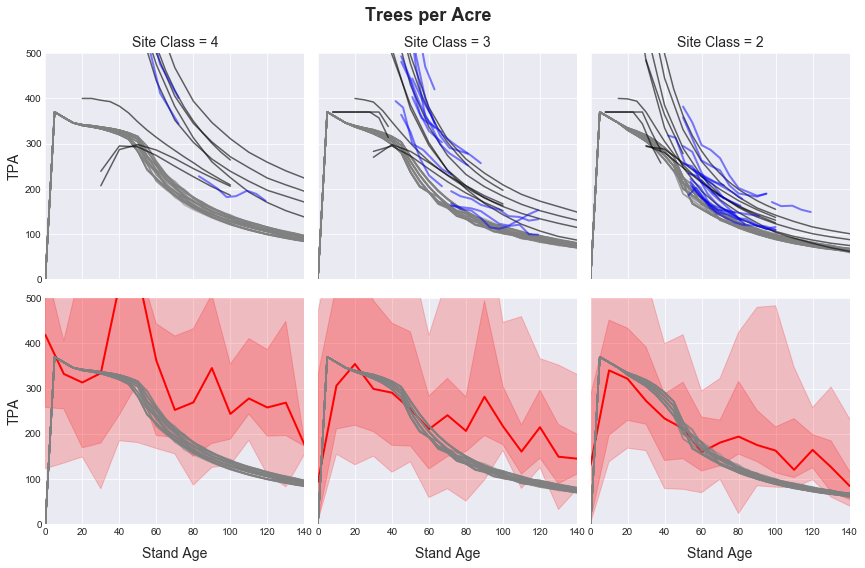

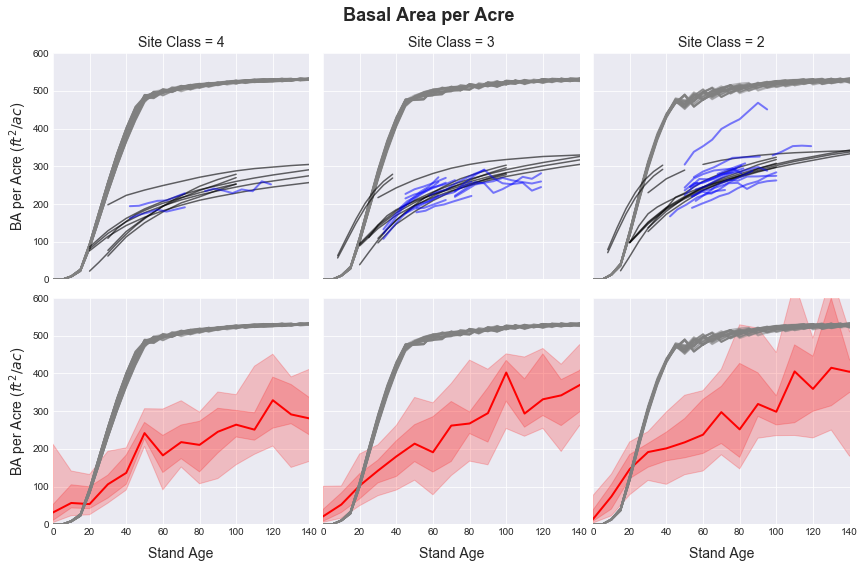

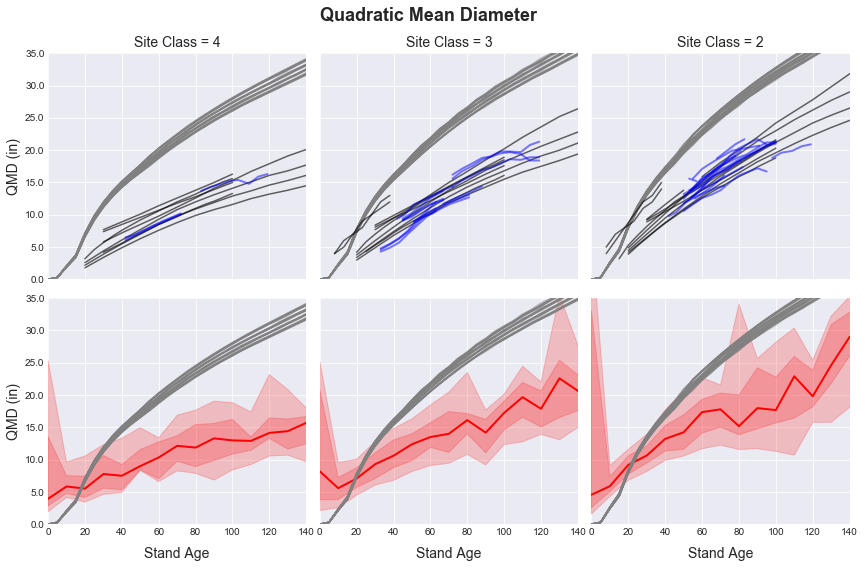

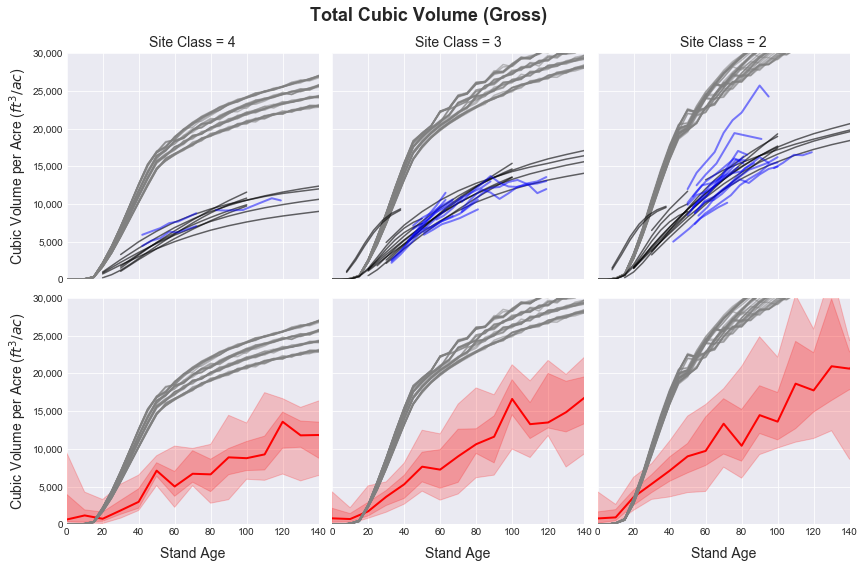

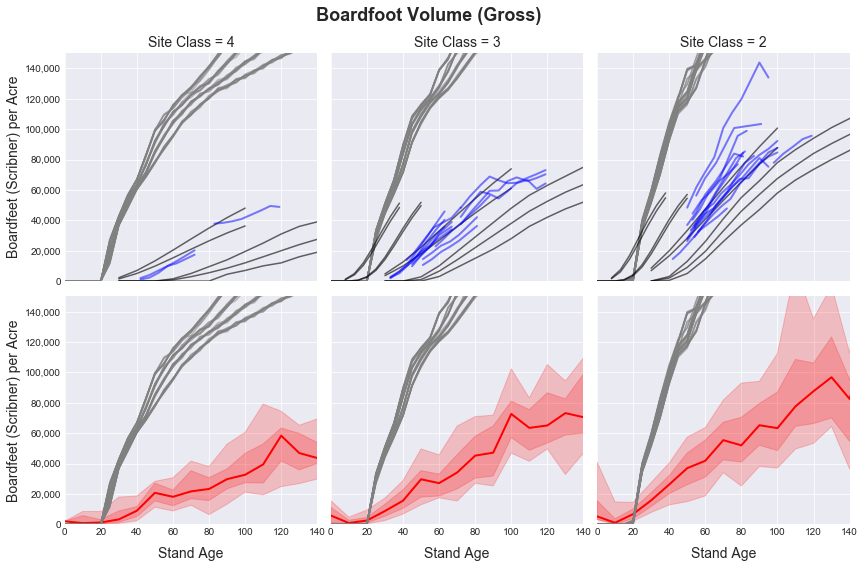

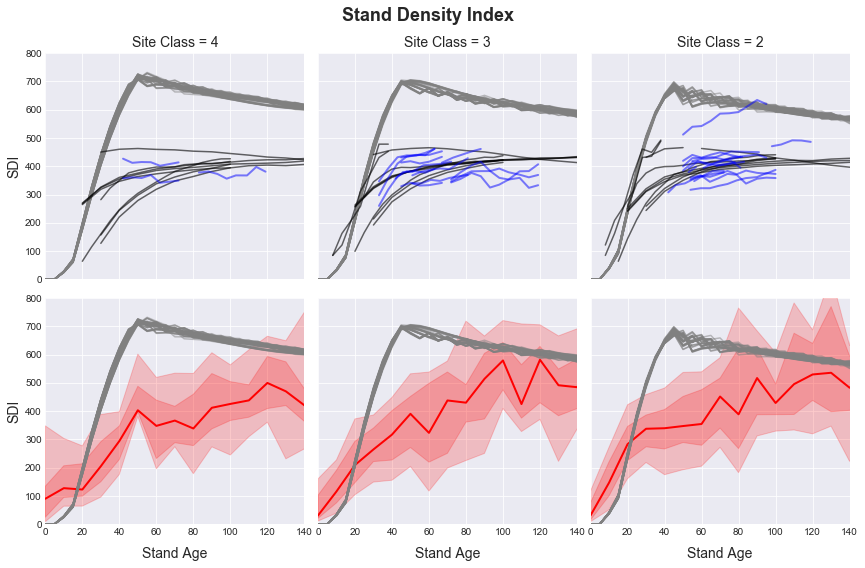

In [72]:
for metric in ['tpa', 'ba', 'qmd', 'tcuft', 'bdft', 'sdi']:
    make_yield_plot(metric)